<a href="https://colab.research.google.com/github/Ashish-kumar7/Minor-Project/blob/main/Brain_Tumour_Detection_Using_UNET_Minor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports  different things
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#imports  different things
# tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable.
# A tqdm progress bar not only shows you how much time has elapsed, but also shows the estimated time remaining for the iterable.
# itertools: it is used to iterate over data structures that can be stepped over using a for-loop
# skimage.io: Utilities to read and write images in various formats.
import cv2
from glob import glob
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [ ]:
#imports  different things
# It is an open source artificial intelligence library, 
# using data flow graphs to build models. It allows developers to create large-scale neural networks with many layers. 
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Set parameters
# create a variable IMAGE_SIZE
IMAGE_SIZE = (512, 512)

In [ ]:
#Connect to google drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#created an array named train_files
# mask_files stores all the masked files("files whose names ends with _mask") present in our dataset and puts it in train_files array after removing "_mask" from their names.
# glob is used to return all file paths that match a specific pattern.
train_files = []
mask_files = glob('/content/drive/MyDrive/dataset-brain-tumour/dataset/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask', ''))

In [ ]:
# dataframes(table) are created using panda library using images of train_files and mask_files
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

# daignosis function is created 
# using numpy library find the maximum of the all the pixel present in the image
# since our masked tumour is white which has (255,255,255)  rgb value hence we can  easiluy say if white is present means there is tumour.

def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

#store it in dataframe
df['mask'] = df["mask_path"].apply(lambda x: diagnosis(x))

In [ ]:
# print the dataframe
df.head()

,image_path,mask_path,mask
0,/content/drive/MyDrive/dataset-brain-tumour/da...,/content/drive/MyDrive/dataset-brain-tumour/da...,1
1,/content/drive/MyDrive/dataset-brain-tumour/da...,/content/drive/MyDrive/dataset-brain-tumour/da...,1
2,/content/drive/MyDrive/dataset-brain-tumour/da...,/content/drive/MyDrive/dataset-brain-tumour/da...,0
3,/content/drive/MyDrive/dataset-brain-tumour/da...,/content/drive/MyDrive/dataset-brain-tumour/da...,1
4,/content/drive/MyDrive/dataset-brain-tumour/da...,/content/drive/MyDrive/dataset-brain-tumour/da...,0


In [ ]:
# checks the count where 0 represents no tumour and 1 represents tumour is present
df['mask'].value_counts()

0    1166
1     673
Name: mask, dtype: int64

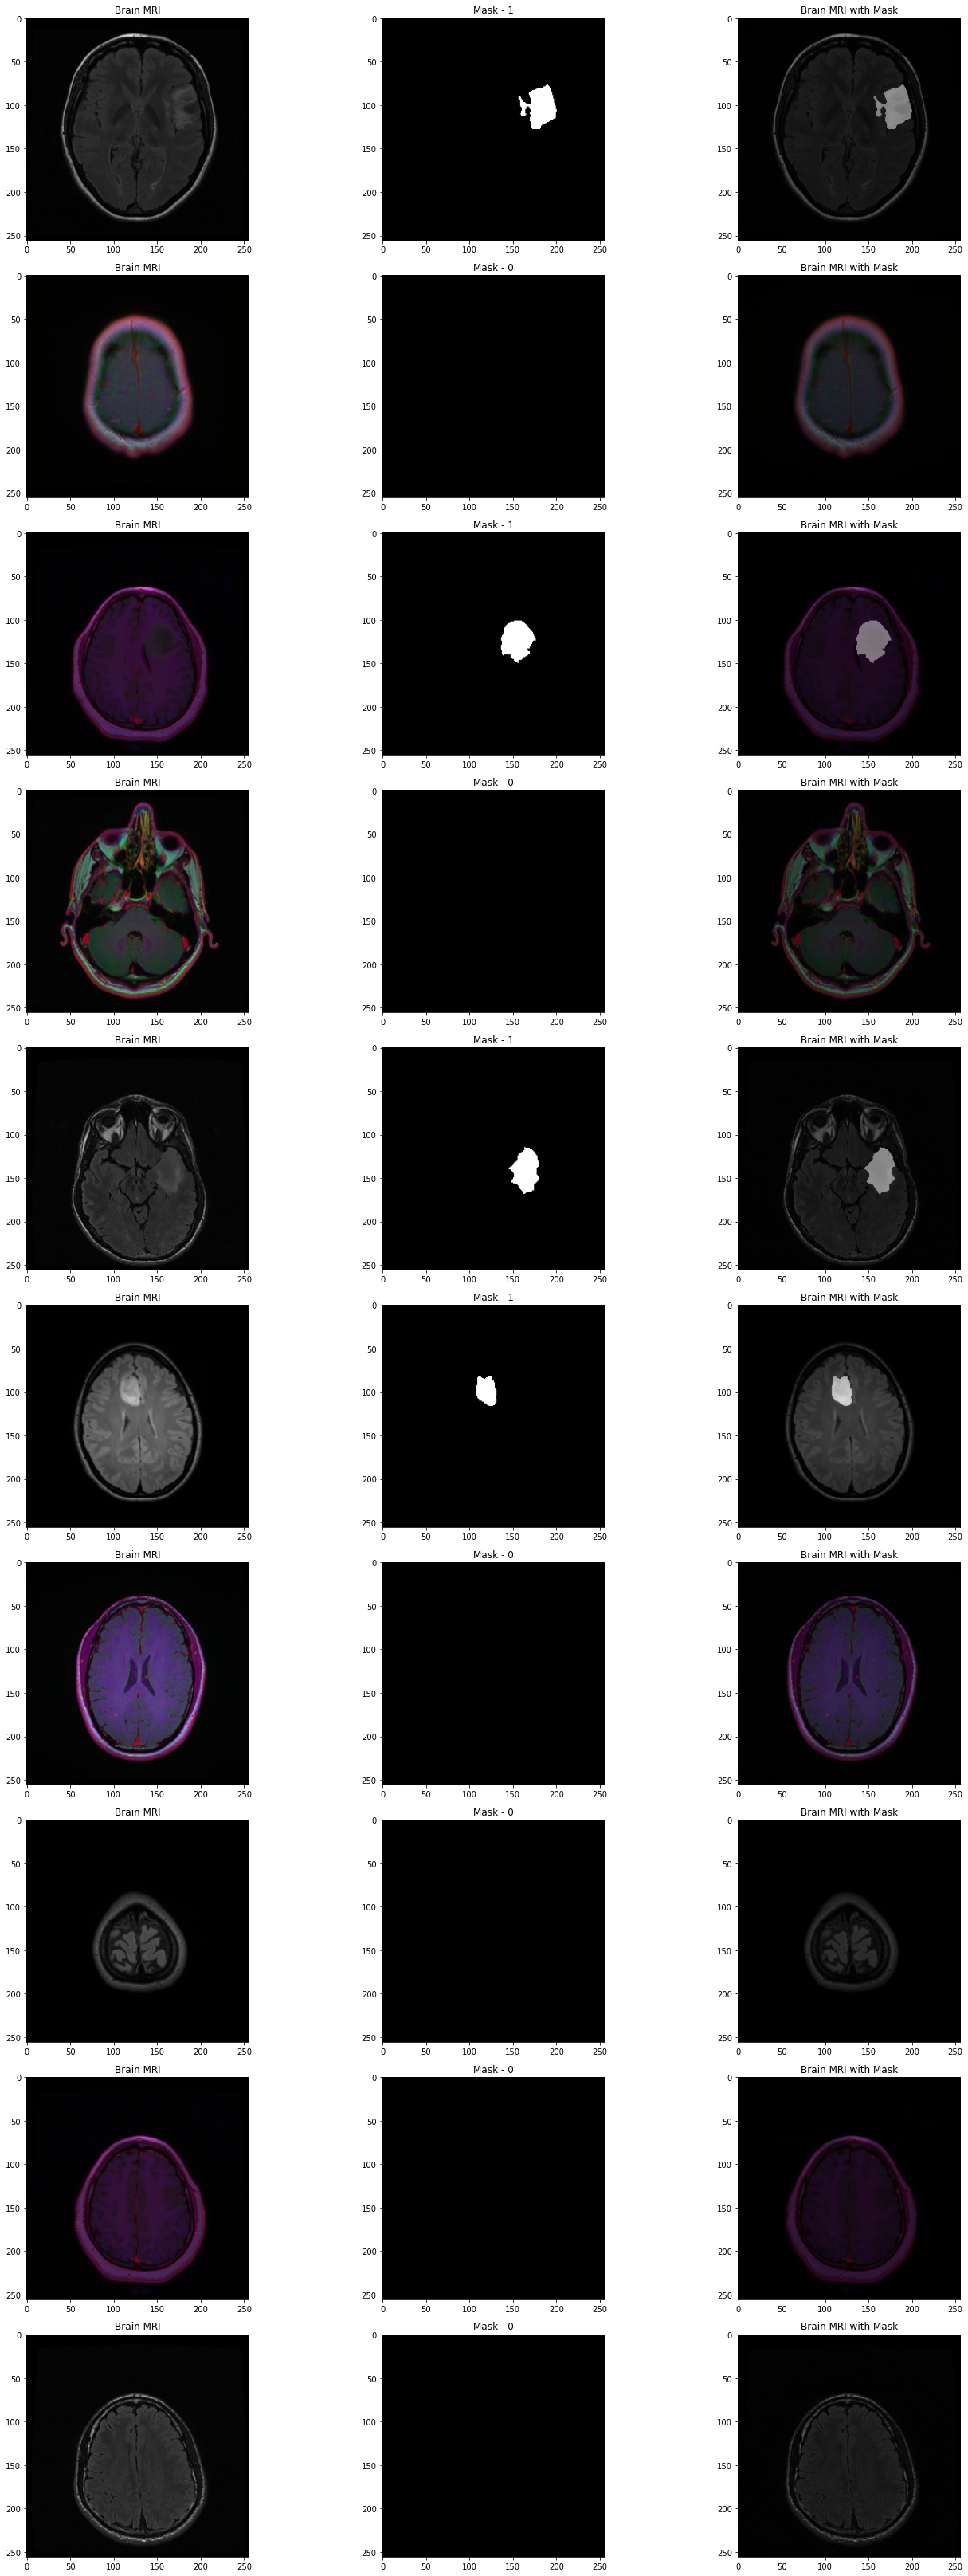

In [ ]:
# creates a table of size 10 x 3 . Figure size (20 x 45)
# the dataframe which is created above  we are printing any random 10 images from it.
# Visualize some random images with their tumor (if exist)
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
    i = random.randint(0, len(df))
    img = cv2.imread(df['image_path'][i])
    mask = cv2.imread(df['mask_path'][i])
    ax[x][0].title.set_text("Brain MRI")
    ax[x][0].imshow(img)
    ax[x][1].title.set_text("Mask - " + str(df['mask'][i]))
    ax[x][1].imshow(mask)
    ax[x][2].title.set_text("Brain MRI with Mask")
    ax[x][2].imshow(img)
    ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

In [ ]:
# converts 0/1 into string format
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1839 non-null   object
 1   mask_path   1839 non-null   object
 2   mask        1839 non-null   object
dtypes: object(3)
memory usage: 43.2+ KB


In [ ]:
#train_test_split() function which splits the entire dataframe into train , validate and test dataset
# test data size=15%
# train data size=85% of 85%
# validate data size= 15% of 85%

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(1328, 3)
(235, 3)
(276, 3)


In [ ]:
#Model 2
# function train_generator is created passing various diff parameters
# Keras ImageDataGenerator  lets you augment your images in real-time while 
# your model is still training. You can apply any random transformations on each training image as
# it is passed to the model. This will not only make your model robust but will also save up on the overhead memory
# thresholding
# maksed image and image is augmented(highly enlarged) and  then it is thresholded i.e divided by a factor to check its actual existence
# then the false white(earlier appeared gray) is asssigned 0 value and the other is assigned 1 value.
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(512,512),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
# zipped as tuple into train_gen
    train_gen = zip(image_generator, mask_generator)
    
#calls fucntion adjust data for each tuple of train_gen
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)
        
def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
# calculate the dice coefficient.
# Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images.
# iou: Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset

smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [ ]:
# Using UNet Model for Brain MRI Segmentation
# for the 1st one : 
# filter=32
# kernel_size=(3,3)
# similarly for all
# it is done many times changing the filter each time.  


def unet(input_size=(512,512,3)):
    inputs = Input(input_size)
    
    
    conv0 = Conv2D(32, (3, 3), padding='same')(inputs)
    bn0 = Activation('relu')(conv0)
    conv0 = Conv2D(32, (3, 3), padding='same')(bn0)
    bn0 = BatchNormalization(axis=3)(conv0)
    bn0 = Activation('relu')(bn0)
    pool0 = MaxPooling2D(pool_size=(2, 2))(bn0)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(pool0)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)
    
    up10 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(bn9), conv0], axis=3)
    conv10 = Conv2D(32, (3, 3), padding='same')(up10)
    bn10 = Activation('relu')(conv10)
    conv10 = Conv2D(32, (3, 3), padding='same')(bn10)
    bn10 = BatchNormalization(axis=3)(conv10)
    bn10 = Activation('relu')(bn10)

    conv11 = Conv2D(1, (1, 1), activation='sigmoid')(bn10)

    return Model(inputs=[inputs], outputs=[conv11])


In [ ]:
#Training
# Set parameters
#epoch: just a varible to represent the iteration numbers 
# batch_size: batch_size denotes the subset size of your training sample (e.g. 100 out of 1000)
# which is going to be used in order to train the network during its learning process.
# learning_rate : The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates 
# require more training epochs given the smaller changes 
# made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs

EPOCHS = 3
BATCH_SIZE = 16
learning_rate = 1e-4

In [ ]:
# train_generator_args is a dictionary (is mapping done in form of key- value pair.)

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# train_generator augment krke chota kr rha hai on train datasets
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)

# train_generator augment krke chota kr rha hai on validation datasets   
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)

#  Model groups layers into an object with training and inference features.
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('a_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Found 1328 validated image filenames.
Found 1328 validated image filenames.
Epoch 1/3
83/83 [==============================] - ETA: 0s - loss: -0.0518 - binary_accuracy: 0.7408 - iou: 0.0268 - dice_coef: 0.0518  Found 235 validated image filenames.
Found 235 validated image filenames.
83/83 [==============================] - 11699s 141s/step - loss: -0.0518 - binary_accuracy: 0.7408 - iou: 0.0268 - dice_coef: 0.0518 - val_loss: -0.0178 - val_binary_accuracy: 0.8009 - val_iou: 0.0090 - val_dice_coef: 0.0177

Epoch 00001: val_loss improved from inf to -0.01781, saving model to a_seg.hdf5
Epoch 2/3
83/83 [==============================] - 11906s 144s/step - loss: -0.0799 - binary_accuracy: 0.9607 - iou: 0.0420 - dice_coef: 0.0799 - val_loss: -0.0228 - val_binary_accuracy: 0.8680 - val_iou: 0.0114 - val_dice_coef: 0.0224

Epoch 00002: val_loss improved from -0.01781 to -0.02278, saving model to a_seg.hdf5
Epoch 3/3
83/83 [==============================] - 11840s 143s/step - loss: -0.0949 -

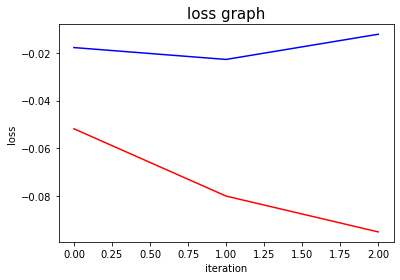

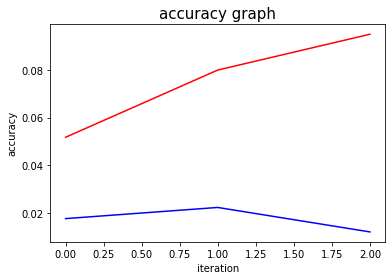

In [ ]:
traindice = history.history['dice_coef'] 
testdice = history.history['val_dice_coef']
trainjaccard = history.history['iou'] 
testjaccard = history.history['val_iou']

trainloss = history.history['loss']
testloss = history.history['val_loss']
plt.figure(1)
plt.plot(testloss, 'b-')
plt.plot(trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(traindice, 'r-')
plt.plot(testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
#saving model to drive
model.save("kaggle_model.h5")

In [ ]:
model.save("kaggle_model2.hdf5")

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 276 validated image filenames.
Found 276 validated image filenames.
17/17 [==============================] - 602s 35s/step - loss: -0.0166 - binary_accuracy: 0.8972 - iou: 0.0084 - dice_coef: 0.0166
Test lost:  -0.016587307676672935
Test IOU:  0.8971617817878723
Test Dice Coefficent:  0.008440458215773106


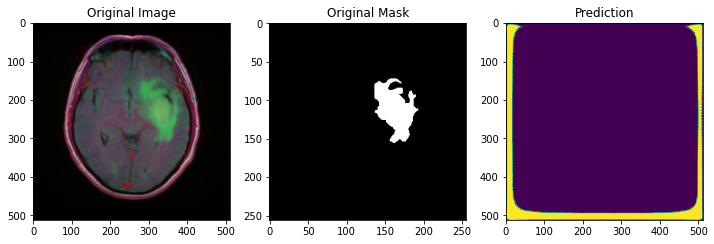

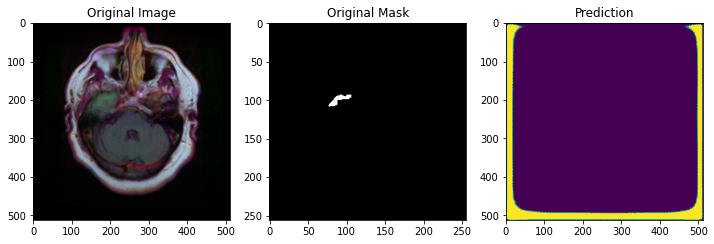

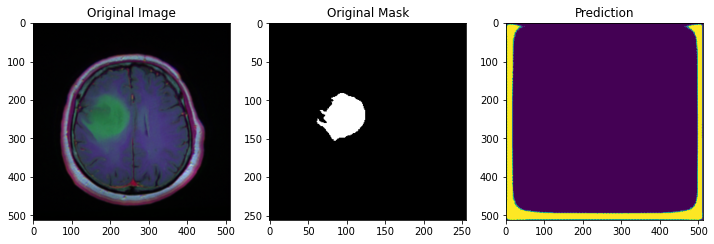

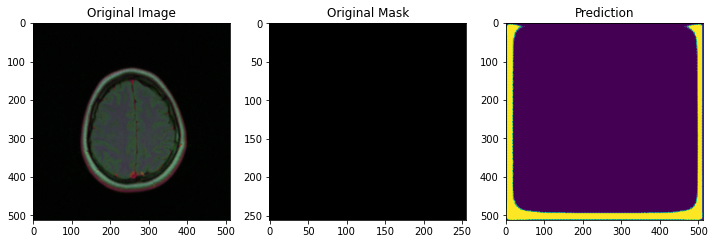

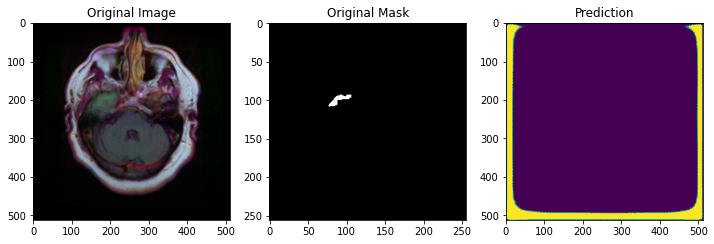

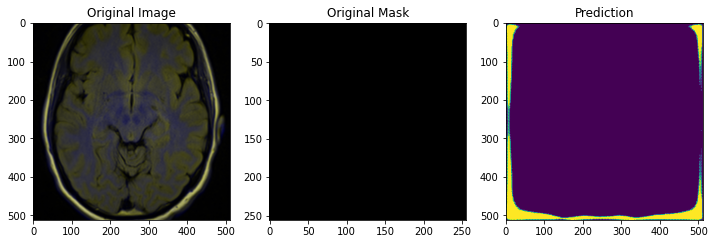

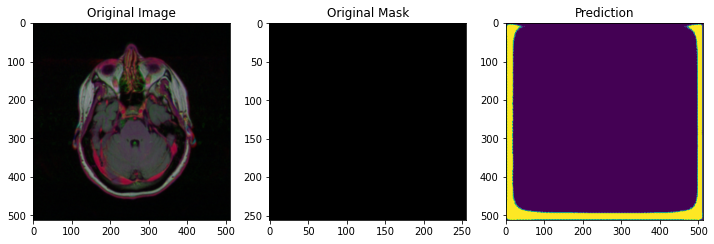

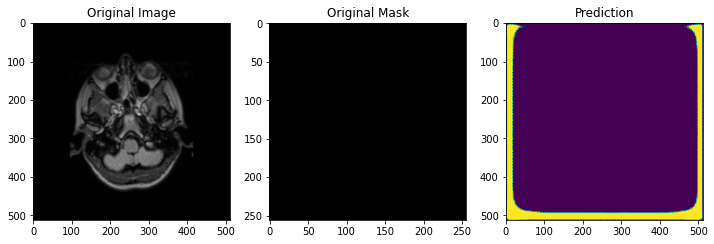

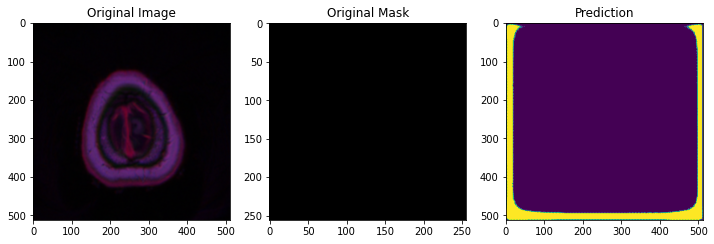

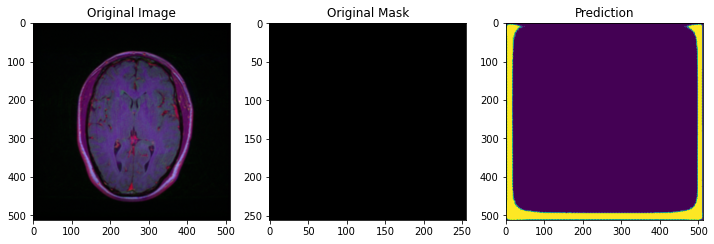

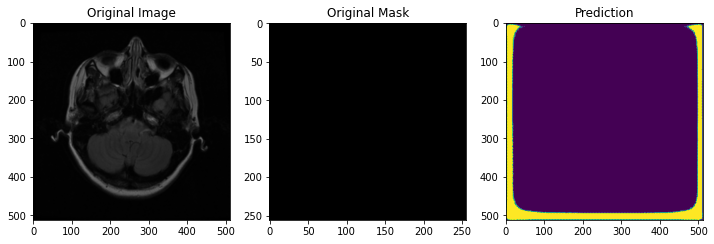

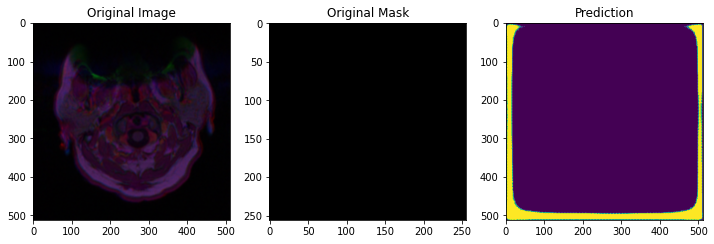

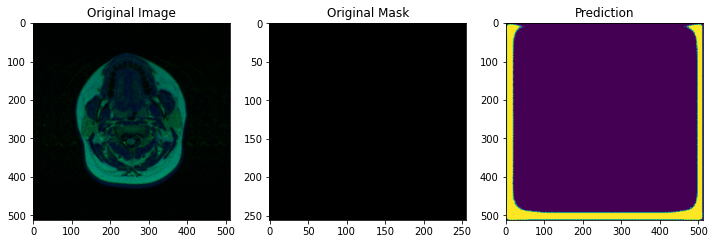

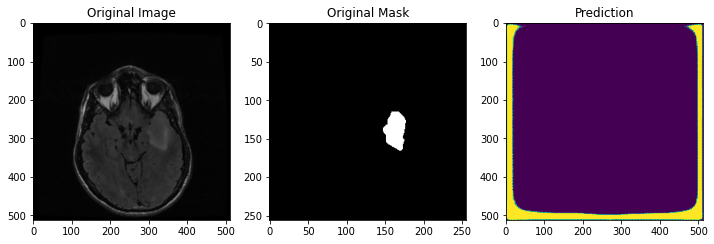

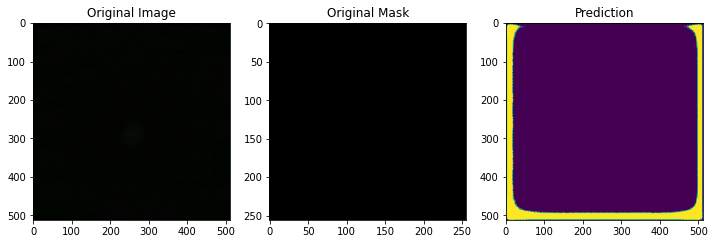

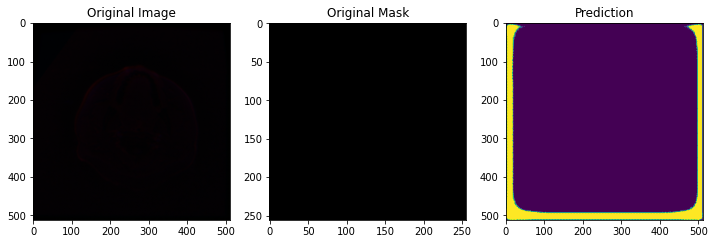

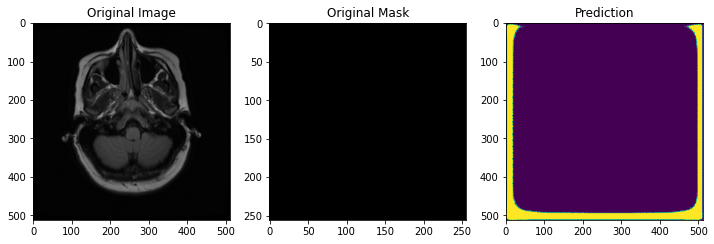

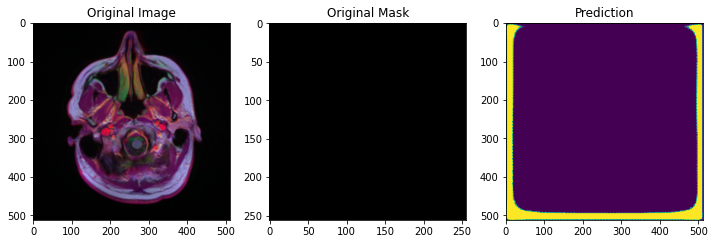

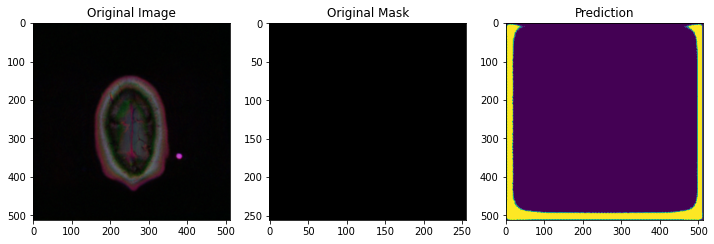

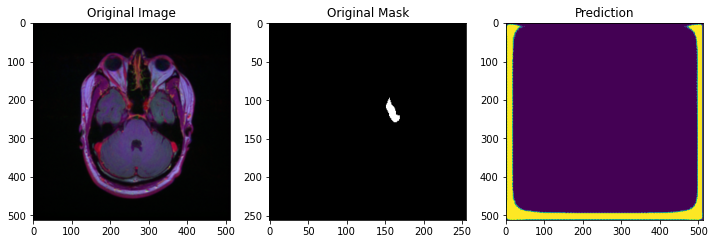

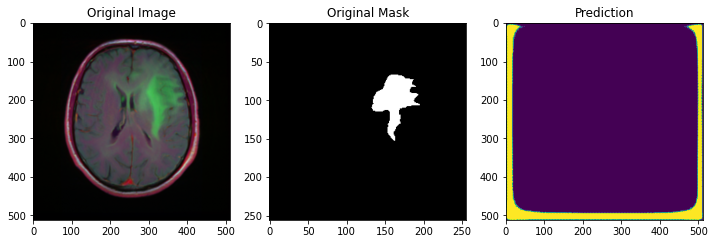

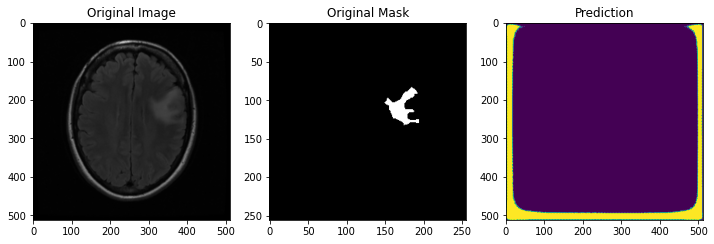

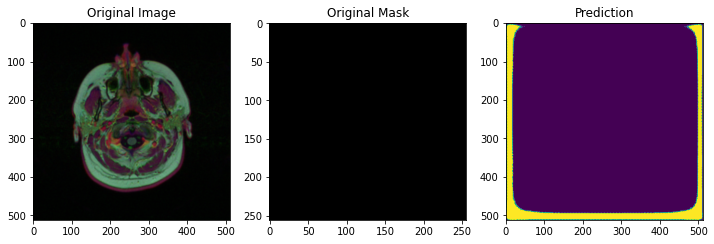

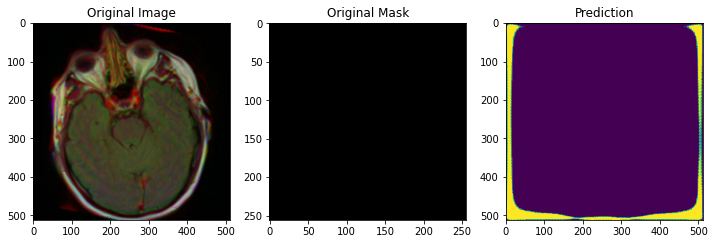

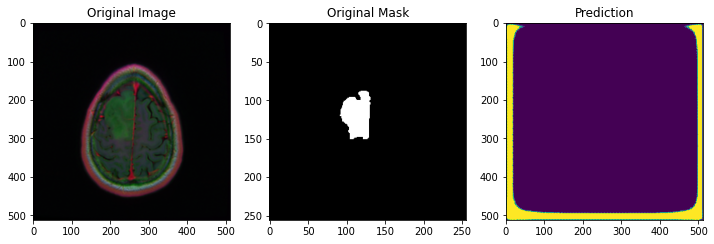

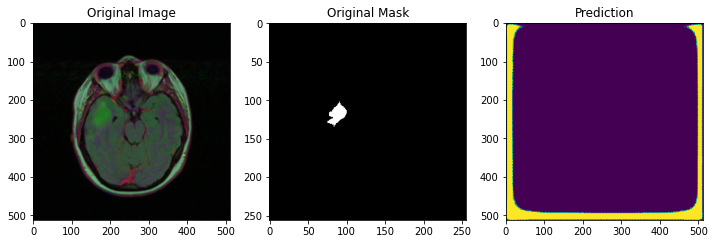

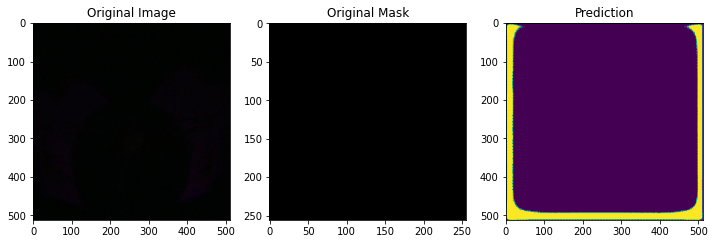

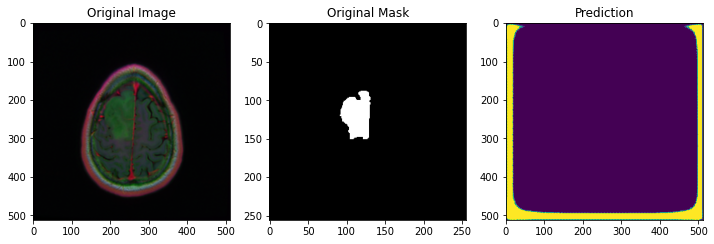

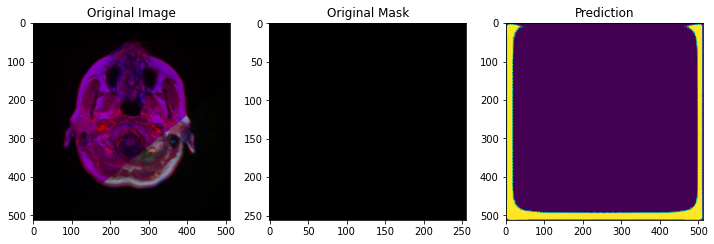

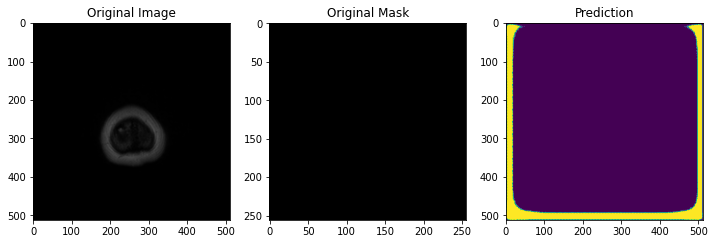

In [ ]:
################################################################################################
# outputing the results on the test dataset
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [ ]:
import os 
os.chdir(r'/kaggle/working')
%cd /kaggle/working

FileNotFoundError: ignored